Train and Deploy a CNN Model Using TensorFlow Serving

In [6]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2024-09-12 01:38:20.250593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 01:38:20.545399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 01:38:20.656597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 01:38:20.689092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 01:38:20.901886: I tensorflow/core/platform/cpu_feature_guar

Importing dataset of images and csv file containing the labels of the images. We use this csv file to create new folders of train and test that will each will include images distributed with respect to their labels into sub-folders belonging to each class. Before moving the images into their respective class each image is pre-processed to correct for noise, exposure correcting and resize image to 256x256.

In [2]:

# Directories and file paths
data_dir = 'data'
labels_csv = 'Labels.csv'
train_dir = 'data/train'
val_dir = 'data/val'

# Load the labels CSV
labels_df = pd.read_csv(labels_csv)

# Function to get the image path 
def get_image_path(image_id, data_dir):
    image_name = f"{image_id}.jpeg"
    return os.path.join(data_dir, image_name) if os.path.isfile(os.path.join(data_dir, image_name)) else None

# Apply the function to get the image path
labels_df['image_path'] = labels_df['image'].apply(lambda x: get_image_path(x, data_dir))
labels_df = labels_df.dropna(subset=['image_path'])

# Split data into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Create directories for training and validation data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

def create_class_dirs(df, base_dir):
    classes = df['level'].unique()
    for cls in classes:
        os.makedirs(os.path.join(base_dir, str(cls)), exist_ok=True)

create_class_dirs(train_df, train_dir)
create_class_dirs(val_df, val_dir)
# Preprocessing and moving images
def preprocess_and_move_images(df, base_dir):
    # Iterate through each row of the DataFrame
    for idx, row in df.iterrows():
        image_path = row['image_path']
        label = str(row['level'])  # Get the label as a string

        # Load the image
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Image not found or can't be read: {image_path}")
                continue

            # Preprocessing steps
            image = cv2.GaussianBlur(image, (5, 5), 0)  # Noise reduction
            image = cv2.convertScaleAbs(image, alpha=1.2, beta=20)  # Exposure correction
            image = cv2.resize(image, (256, 256))  # Resize image to target size

            # Save the preprocessed image in the class directory
            dest_dir = os.path.join(base_dir, label)
            os.makedirs(dest_dir, exist_ok=True)  # Ensure directory exists

            # Define destination path
            dest_path = os.path.join(dest_dir, os.path.basename(image_path))

            # Save the processed image
            cv2.imwrite(dest_path, image)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

preprocess_and_move_images(train_df, train_dir)
preprocess_and_move_images(val_df, val_dir)


Premature end of JPEG file
Premature end of JPEG file


We use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2. Both generators will be initialized with data normalization. And we load train, validation and test dataset in batches of 32 using the generators with image size of 256*256. Moreover the train generator will also augment the images as they are been fed to the CNN.

In [3]:

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)



Found 13441 images belonging to 5 classes.
Found 3361 images belonging to 5 classes.


Next we build a CNN network using Keras, then compile it using Adam optimizer, categorical_crossentropy loss, and with metrics accuracy. Next since the classes are imbalanced and can lead to over-fitting, we compute the class weights of the sub-folders of images using train_generator.classes and moreover create a early stopping callback to deal with over-fitting, as well as using a model checkpoint to monitor and save best model. We use this class weights and early stopping to fit the model for 50 epochs, and plot training loss and accuracy against epochs.

In [4]:
from sklearn.utils.class_weight import compute_class_weight
# Define CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])
    return model

model = create_cnn_model()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Calculating class weights to address imbalance
# Get the class indices for the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

# Define callbacks
checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)

print("Model training complete and saved.")


/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1726081561.126733     850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726081561.539661     850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726081561.539744     850 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726081561.545911     850 

Epoch 1/50


/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726081567.674878    7291 service.cc:146] XLA service 0x7f6640016e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726081567.675068    7291 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-09-11 20:06:07.753804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-11 20:06:07.970602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN versi

  2/421 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.6094 - loss: 1.1214

I0000 00:00:1726081573.407554    7291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3354 - loss: 1.6224
Epoch 1: val_accuracy improved from -inf to 0.62809, saving model to model_checkpoint.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 99s 216ms/step - accuracy: 0.3358 - loss: 1.6223 - val_accuracy: 0.6281 - val_loss: 1.5822
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4665 - loss: 1.6106
Epoch 2: val_accuracy did not improve from 0.62809
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 185ms/step - accuracy: 0.4665 - loss: 1.6105 - val_accuracy: 0.2029 - val_loss: 1.5607
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4860 - loss: 1.5604
Epoch 3: val_accuracy improved from 0.62809 to 0.65635, saving model to model_checkpoint.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 184ms/step - accuracy: 0.4859 - loss: 1.5605 - val_accuracy: 0.6564 - val_loss: 1.5124
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.3594 - loss: 1.6375
Epoch 4: val_accuracy did not improve from 0.65635
421/421 ━━

Finally, we evaluate the model on validation images and print the test loss and accuracy and plot heatmap of the confusion matrix and print classification report. However, we get a average performing model as the model has only 54% accuracy with validation images, since the dataset images used is half of the original dataset due to storage restrictions. We will save this model and use docker to serve the model as a tensorflow serving container to make it available for inference and prediction tasks.   

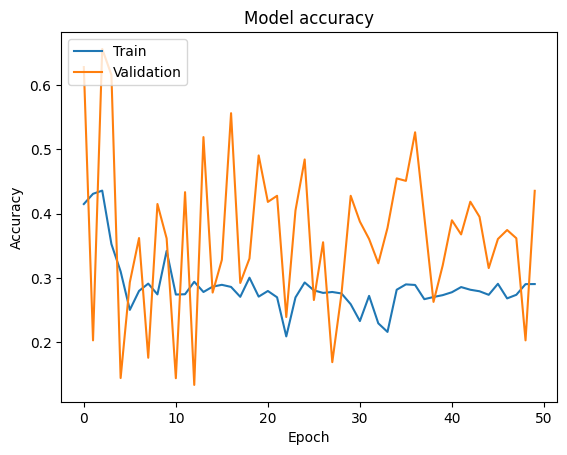

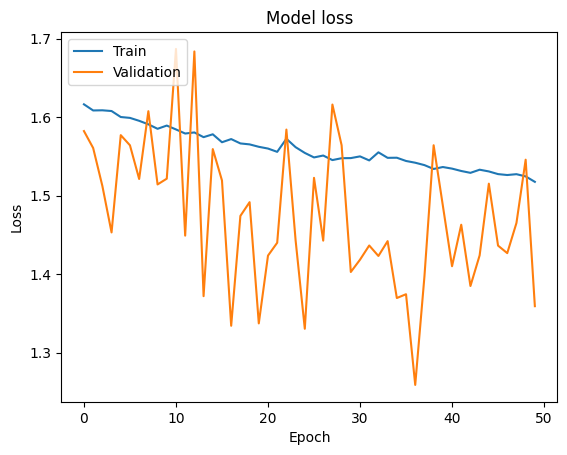

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5293 - loss: 1.2496
Test Loss: 1.258989930152893
Test Accuracy: 0.5266289710998535
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


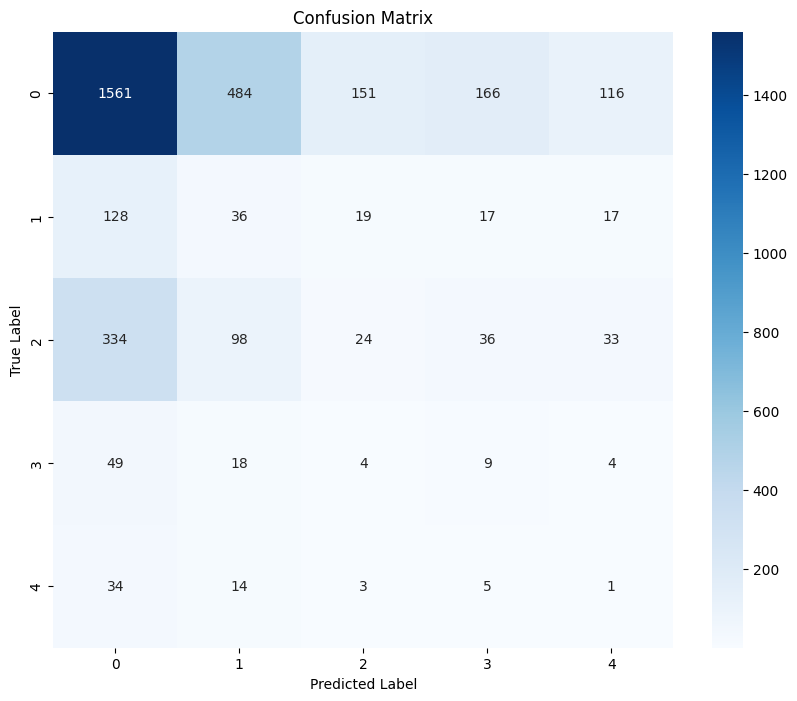

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      2478
           1       0.06      0.17      0.08       217
           2       0.12      0.05      0.07       525
           3       0.04      0.11      0.06        84
           4       0.01      0.02      0.01        57

    accuracy                           0.49      3361
   macro avg       0.19      0.19      0.18      3361
weighted avg       0.57      0.49      0.52      3361

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


Saved artifact at 'saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140084547770832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547770448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547771600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547771984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547769296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547772368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547772560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547773136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547771408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140084547774096: TensorSpec(shape=(), dtype=tf.resource, name=None)
SavedModel files: [

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import keras as k

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_generator, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get the true labels and predictions
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


model_dir = "models/saved_model"
model_version = 1
model_export_path = f"{model_dir}/{model_version}"
model.export(model_export_path)

print(f"SavedModel files: {os.listdir(model_export_path)}")


Next we pre-process an validation image and and send the image as a request to the tensorflow serving container and get a prediction.

In [13]:
import requests
import numpy as np
import cv2

def preprocess_image(image_path):
  """
  Preprocesses the image to match the model's input shape.
  """
  image = cv2.imread(image_path)
  if image is None:
      raise ValueError(f"Could not read image from {image_path}")

  # Preprocessing steps
  image = cv2.GaussianBlur(image, (5, 5), 0)
  image = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
  image = cv2.resize(image, (256, 256))  # Resize to match model's input
  image = image / 255.0  # Normalize

  # Print the shape for verification
  print("Preprocessed image shape:", image.shape) 

  return image

def predict_from_tf_serving(image_path):
  """
  Sends a request to TensorFlow Serving and returns the prediction.
  """
  try:
      # Preprocess the image
      image = preprocess_image(image_path)

      # Prepare the data for the request. Ensure it's a list of lists
      data = {
          "instances": [image.tolist()]  # Wrap the image in an extra list
      }

      # Send the request to TensorFlow Serving
      response = requests.post("http://localhost:8501/v1/models/saved_model:predict", json=data)

      # Check for successful response
      response.raise_for_status()

      # Parse the response
      predictions = response.json()['predictions'][0]

      # Get the predicted class
      predicted_class = np.argmax(predictions)

      return predicted_class

  except requests.exceptions.RequestException as e:
      print(f"Error during prediction: {e}")
      return None

# Example usage
image_path = 'data/val/0/10_left.jpeg' 
predicted_class = predict_from_tf_serving(image_path)

if predicted_class is not None:
    print(f'Predicted class: {predicted_class}')
else:
    print("Prediction failed. Check the error message above.")

Preprocessed image shape: (256, 256, 3)
Predicted class: 4
